# Simulation of a cross-well EM survey for detecting an electrically conductive fractured region

Neglect the role of steel-cased wells, here we are only looking at the feasibility of detecting a fractured volume of rock with a cross-well survey

The simulation is performend on a cylindrically symmetric mesh

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LogNorm
from matplotlib import colorbar
from pymatsolver import Pardiso

import discretize
from SimPEG import (
    Maps, Regularization, DataMisfit, Optimization, 
    Inversion, Directives, InvProblem
)
from SimPEG.EM import FDEM

%matplotlib inline

In [3]:
rcParams['font.size'] = 12

## Proppant-fluid mixture parameters

- set the conductivity of the proppant, and fluid
- use effective medium theory to estimate the bulk conductivity

In [5]:
sigma_proppant = 1e4
sigma_fluid = 3
phi_proppant = 0.5

scemt = Maps.SelfConsistentEffectiveMedium(sigma0=sigma_fluid, sigma1=sigma_proppant)
sigma_pf = (scemt * np.r_[phi_proppant])[0]

print("The estimated conductivity of the proppant-fluid mixture is {:1.0f} S/m".format(sigma_pf))

The estimated conductivity of the proppant-fluid mixture is 2507 S/m


## Fracture geometry

- typical frac between 5000 and 25000 bbls of proppant-fluid slurry 

In [6]:
bbl_to_m3 = 0.1589873
slurry_bounds = np.r_[5000, 25000] * bbl_to_m3
proppant_perc_vol = [0.1, 0.2]

print(
    'typical fracs use between {:1.0f} m3 and {:1.0f} m3 of proppant-fluid slurrey'.format(
        slurry_bounds[0],  slurry_bounds[1]
    )
)

print(
    'that mixture usually contains 10-20% proppant (lower: {:1.0f} - {:1.0f} m3)'.format(
        slurry_bounds[0]*proppant_perc_vol[0], slurry_bounds[0]*proppant_perc_vol[1]
    )
)

typical fracs use between 795 m3 and 3975 m3 of proppant-fluid slurrey
that mixture usually contains 10-20% proppant (lower: 79 - 159 m3)


- estimate the volume of the fractured volume of rock
- divide that volume among 10 fracs and estimate the radius

In [7]:
V_frac = slurry_bounds[0]*np.mean(proppant_perc_vol)/phi_proppant  # for simplicity, work with 800m^3 volume 
n_fracs = 10  # number of fractures
t_frac = 3e-3 # thickness of the fracture 
w_frac = 10 # 10m wide fracture zone

# approximate the fracs as circular
V_frac_i = V_frac/n_fracs
r_frac = np.sqrt(V_frac_i / (np.pi * t_frac))

print("the radius of the fractures is: {:1.2f}".format(r_frac))

the radius of the fractures is: 50.30


In [8]:
r = np.round(r_frac)

## Geology and conductivity of the fractured rock

In [9]:
sigma_back = 0.1

treat the fractured zone as a 10m wide zone with 10 fracs in it

In [10]:
V_total = np.pi * r**2 * w_frac
V_frac = np.pi * r**2 * t_frac*n_fracs
phi_frac = V_frac/V_total

print("The concentration of fractures by volume is {}".format(phi_frac))

The concentration of fractures by volume is 0.003


In [11]:
alpha = (t_frac*0.5)/50

print("We assume an aspect ratio of {}".format(alpha))

We assume an aspect ratio of 3e-05


### Isotropic conductivity

In [12]:
scemt_isotropic = Maps.SelfConsistentEffectiveMedium(
    sigma0=sigma_back, sigma1=sigma_pf, alpha1=alpha
)

In [15]:
sigma_frac_iso = scemt_isotropic * np.r_[phi_frac]
print("The isotropic conductivity is {:1.2f}".format(sigma_frac_iso[0]))

The isotropic conductivity is 3.44


### Anisotropic conductivity

In [16]:
scemt_anisotropic = Maps.SelfConsistentEffectiveMedium(
    sigma0=sigma_back, sigma1=sigma_pf, alpha1=alpha, random=False
)

In [17]:
sigma_frac_aniso = scemt_anisotropic * np.r_[phi_frac]
print(sigma_frac_aniso)

[[5.1096169  0.         0.        ]
 [0.         5.1096169  0.        ]
 [0.         0.         0.10030154]]


## Set up an FDEM forward simulation

### Mesh
- design the forward simulation mesh

In [22]:
cs = 2.5
ncx = 100
ncz = 100
npx = 20
npz = 20
pf = 1.3

mesh = discretize.CylMesh(
    [[(cs, ncx), (cs, npx, pf)], np.r_[np.pi*2], [(cs, npz, -pf), (cs, ncz), (cs, npz, pf)]], x0='0CC'
)

In [23]:
500/np.sqrt(sigma_back*100)

158.11388300841895

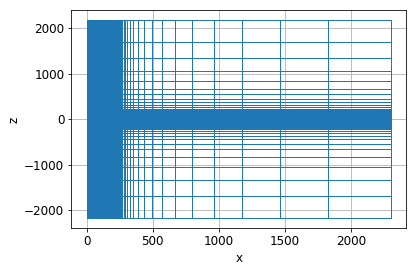

In [24]:
mesh.plotGrid()

In [25]:
print(mesh.nC)

16800


### Models

In [26]:
# indices of the frac
frac_inds = (
    (mesh.gridCC[:, 0] <= r) & (np.absolute(mesh.gridCC[:, 2]) <= w_frac/2.)
)


In [27]:
# background
sigma_background = sigma_back * np.ones(mesh.nC)

# isotropic 
sigma_iso = sigma_back * np.ones(mesh.nC)
sigma_iso[frac_inds] = sigma_frac_iso

# anisotropic
sigma_aniso = sigma_back * np.ones((mesh.nC, 3))
sigma_aniso[frac_inds, :] = sigma_frac_aniso.diagonal()

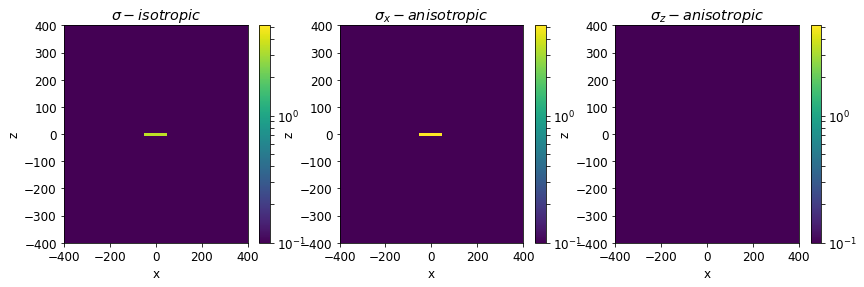

In [28]:
fig, ax = plt.subplots(1, 3, figsize = (14, 4))

xlim = [-400, 400]
zlim = [-400, 400]
clim = [sigma_back, np.max(sigma_frac_aniso.diagonal())]

plt.colorbar(mesh.plotImage(
    sigma_iso, mirror=True, ax=ax[0], clim=clim, pcolorOpts={"norm":LogNorm()}
)[0], ax=ax[0])
ax[0].set_title("$\sigma - isotropic$")

plt.colorbar(mesh.plotImage(
    sigma_aniso[:, 0], mirror=True, ax=ax[1], clim=clim, pcolorOpts={"norm":LogNorm()}
)[0], ax=ax[1])
ax[1].set_title("$\sigma_x - anisotropic$")

plt.colorbar(mesh.plotImage(
    sigma_aniso[:, 2], mirror=True, ax=ax[2], clim=clim, pcolorOpts={"norm":LogNorm()}
)[0], ax=ax[2])
ax[2].set_title("$\sigma_z - anisotropic$")

for a in ax: 
    a.set_xlim(xlim)
    a.set_ylim(zlim)


### Survey parameters

In [29]:
offset = 500
extent = 500
nlocs = 100

rx_locs = np.linspace(-extent, extent, nlocs)

rx_loc_array = discretize.utils.ndgrid([np.r_[offset], np.r_[0], rx_locs])

rx_re = FDEM.Rx.Point_bSecondary(locs=rx_loc_array, orientation='z', component='real')
rx_im = FDEM.Rx.Point_bSecondary(locs=rx_loc_array, orientation='z', component='imag')

rx_list = [rx_re, rx_im]

In [30]:
extent = 100
nlocs = 100
src_locs = np.linspace(-extent, extent, nlocs)

src_loc_array = discretize.utils.ndgrid([np.r_[0], np.r_[0], src_locs])

frequencies = [200]

In [31]:
src_list = [
    FDEM.Src.MagDipole(rxList=rx_list, freq=f, loc=src_loc_array[i, :], orientation="z") for 
    i in range(src_loc_array.shape[0]) for f in frequencies
]

### Construct the forward simulations

In [33]:
prob = FDEM.Problem3D_e(mesh=mesh, sigmaMap=Maps.IdentityMap(mesh), Solver=Pardiso)
survey = FDEM.Survey(src_list)
prob.pair(survey)

In [34]:
prob_aniso = FDEM.Problem3D_e(mesh=mesh, Solver=Pardiso, sigma=sigma_aniso)
survey_aniso = FDEM.Survey(src_list)
prob_aniso.pair(survey_aniso)

### Run the forward simulations

In [35]:
%%time
dpred_background = survey.dpred(sigma_background)

CPU times: user 2.5 s, sys: 226 ms, total: 2.73 s
Wall time: 2.87 s


In [36]:
%%time
dpred_iso = survey.dpred(sigma_iso)

CPU times: user 2.35 s, sys: 187 ms, total: 2.54 s
Wall time: 2.88 s


In [37]:
%%time
dpred_aniso = survey_aniso.dpred(None)

CPU times: user 2.38 s, sys: 192 ms, total: 2.58 s
Wall time: 3.02 s


In [38]:
data = {}
models = ['back', 'iso', 'aniso']
for key, d in zip(models, [dpred_background, dpred_iso, dpred_aniso]):
    d = d.reshape((len(rx_locs), 2, len(src_list)), order="F")
    dreal = d[:, 0, :].squeeze()
    dimag = d[:, 1, :].squeeze()
    data[key] = {"real": dreal, "imag": dimag}

In [39]:
moment = 5000
nT = 1e9

percent_threshold = 5  # %
noise_floor = 1e-4  # nT

In [42]:
masked_difference = {}

for key in models[1:]:
    dreal = moment*(data[key]["real"] - data["back"]["real"])*nT
    dreal = np.ma.masked_where(np.absolute(dreal) < noise_floor, dreal)
    
    dimag = moment*(data[key]["imag"] - data["back"]["imag"])*nT
    dimag = np.ma.masked_where(np.absolute(dimag) < noise_floor, dimag)
    
    masked_difference[key] = {
        "real": dreal,
        "imag": dimag
    }

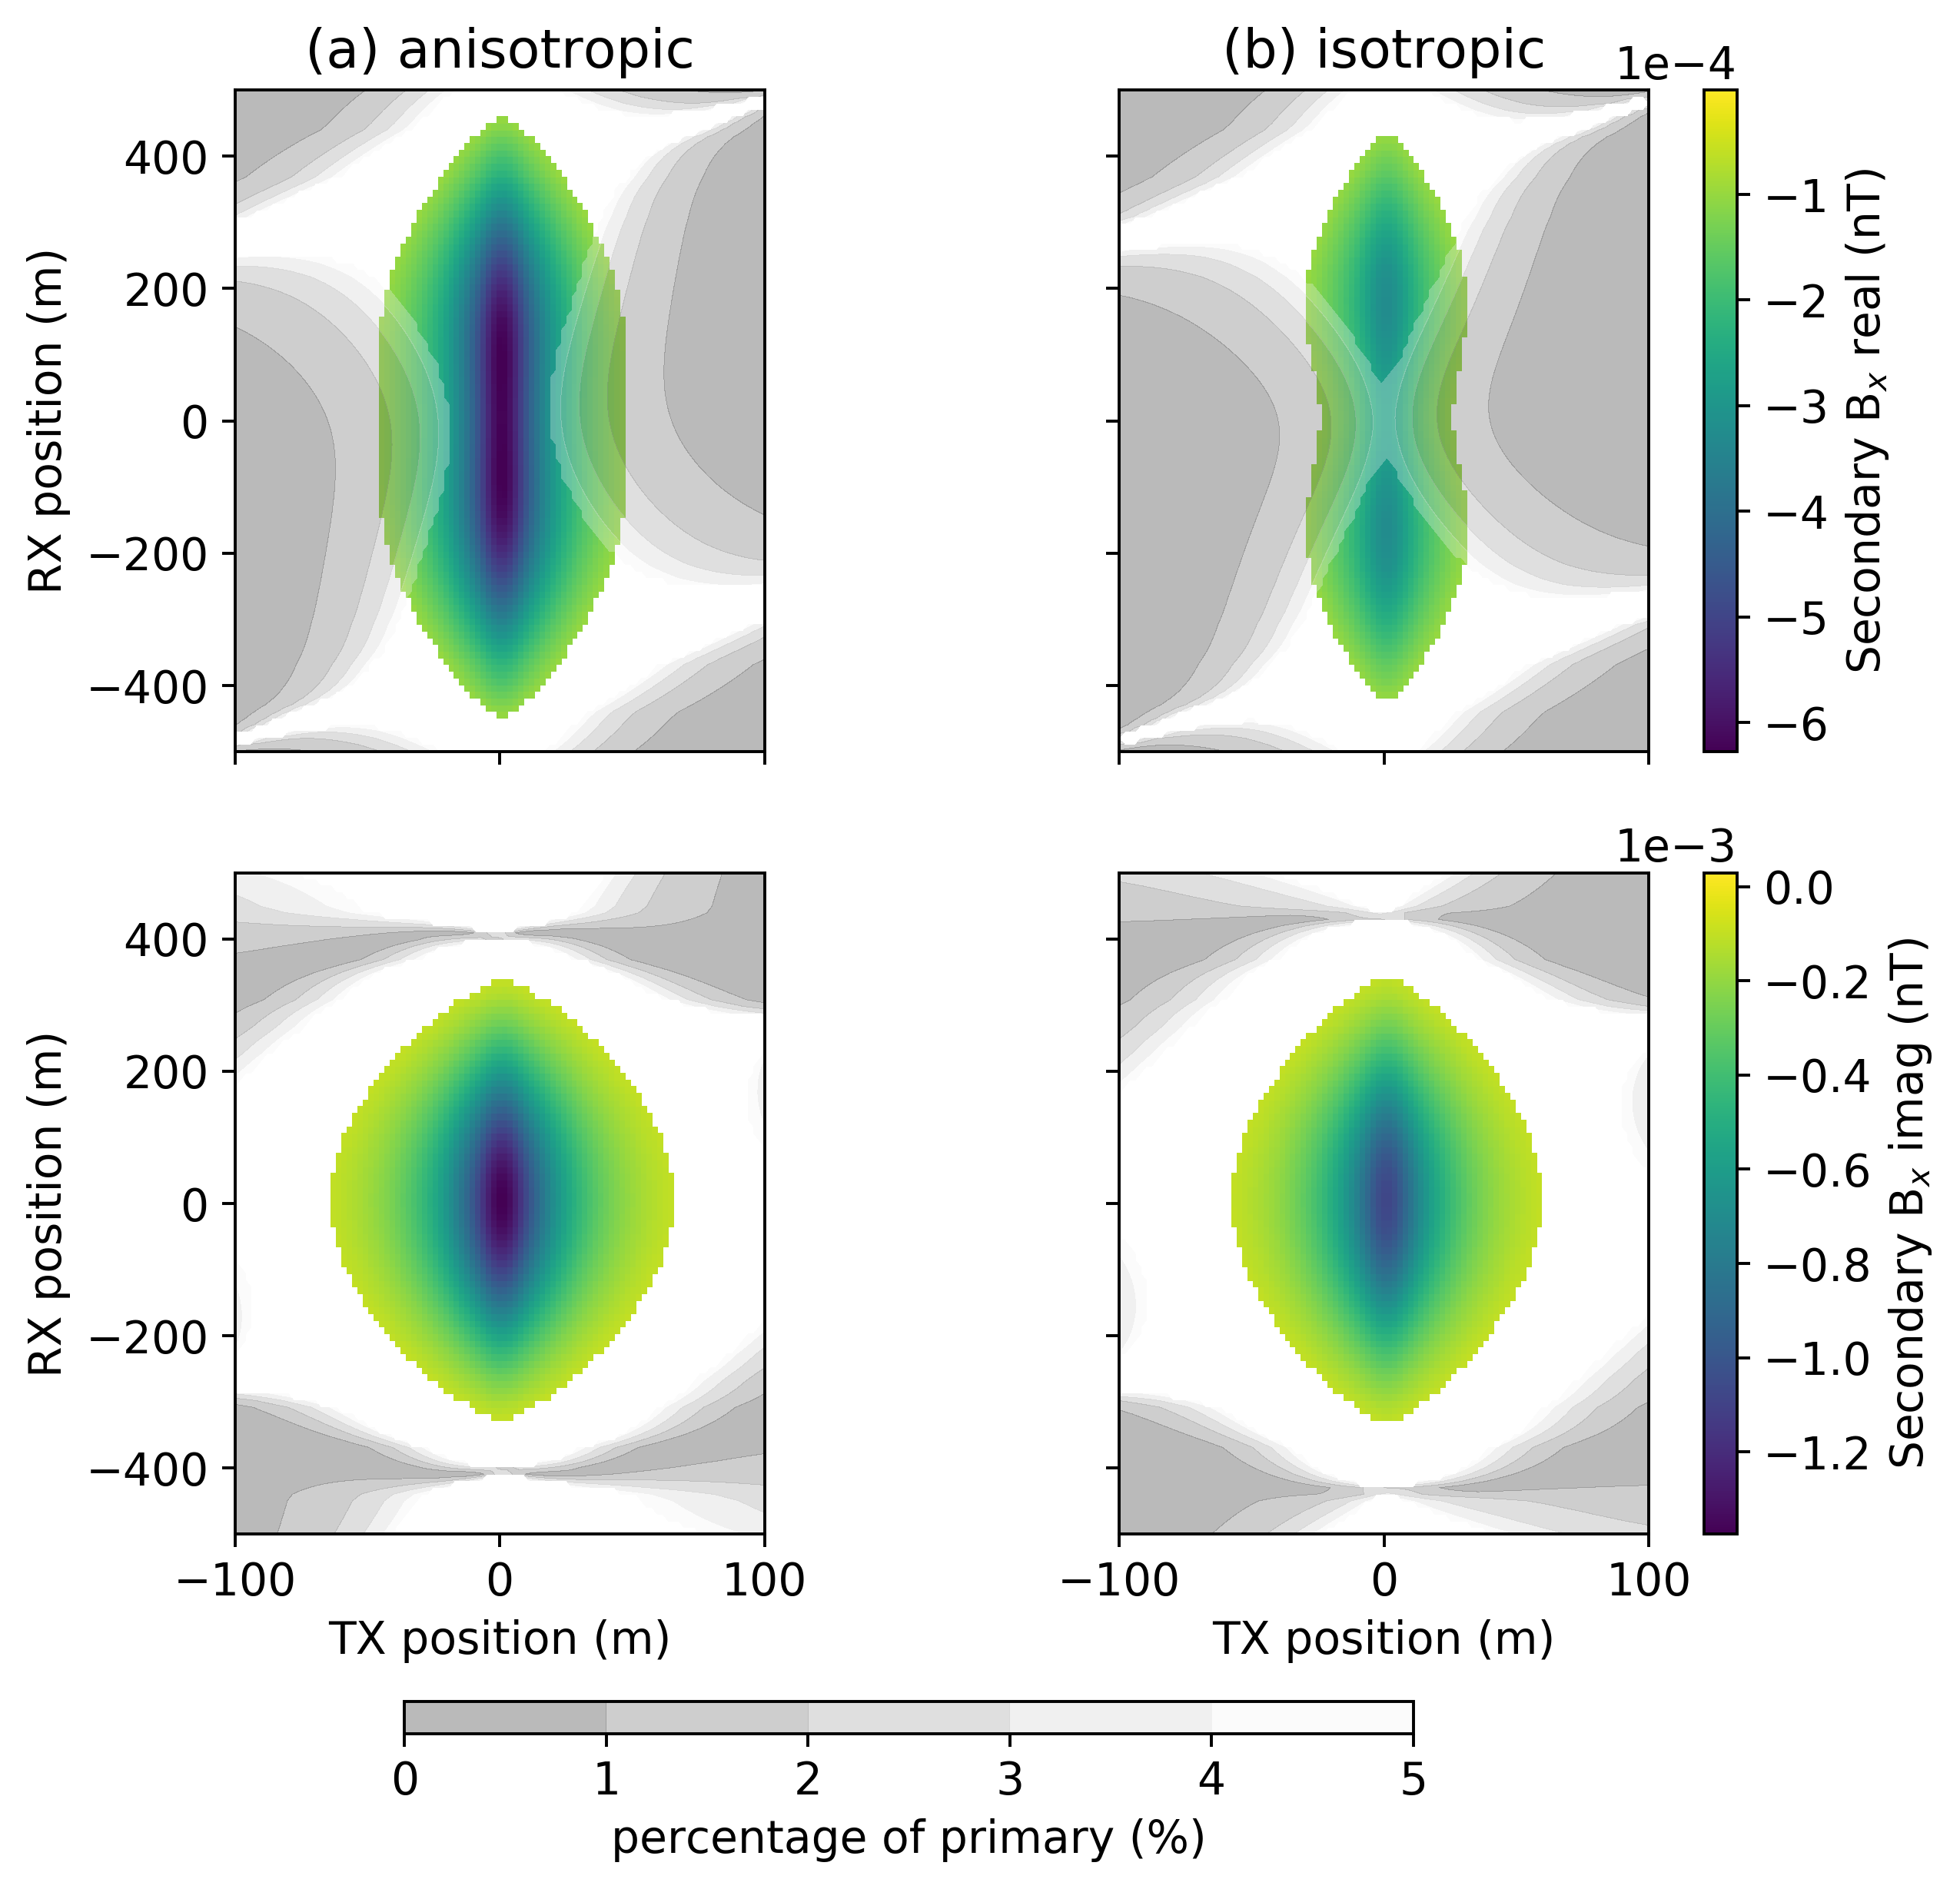

In [43]:
fig, ax = plt.subplots(2, 2, figsize=(7.5, 6), dpi=350)

fig.subplots_adjust(bottom=0.85)

vmin_real = np.min(np.hstack([masked_difference[key]["real"] for key in models[1:]]).flatten())
vmax_real = np.max(np.hstack([masked_difference[key]["real"] for key in models[1:]]).flatten())

vmin_imag = np.min(np.hstack([masked_difference[key]["imag"] for key in models[1:]]).flatten())
vmax_imag = np.max(np.hstack([masked_difference[key]["imag"] for key in models[1:]]).flatten())

for j, key in enumerate(['aniso', 'iso']):
    
    
    dreal_perc = np.absolute(data[key]["real"] - data["back"]["real"])/ (np.absolute(data["back"]["real"])) * 100
    dreal_perc_mask = np.ma.masked_where(dreal_perc >= percent_threshold, dreal_perc)
    
    dimag_perc = np.absolute(data[key]["imag"] - data["back"]["imag"])/ (np.absolute(data["back"]["imag"]))* 100
    dimag_perc_mask = np.ma.masked_where(dimag_perc >= percent_threshold, dimag_perc)
    
    out_real = ax[0, j].pcolor(src_locs, rx_locs, masked_difference[key]["real"], vmin=vmin_real, vmax=vmax_real, )
    out_imag = ax[1, j].pcolor(src_locs, rx_locs, masked_difference[key]["imag"], vmin=vmin_imag, vmax=vmax_imag, )
    
    ax[0, j].contourf(src_locs, rx_locs, dreal_perc_mask, 5, vmin=0, vmax=percent_threshold, cmap=colorbar.cm.Greys_r, alpha=0.3)
    dat_grey = ax[1, j].contourf(src_locs, rx_locs, dimag_perc_mask, 5, vmin=0, vmax=percent_threshold, cmap=colorbar.cm.Greys_r, alpha=0.3)
    
    ax[0, j].set_aspect(0.25)
    ax[1, j].set_aspect(0.25)
    
    plt.tight_layout()
    
    if j > 0:
        cb_re = plt.colorbar(out_real, ax=ax[0, j])
        cb_im = plt.colorbar(out_imag, ax=ax[1, j])
        
        cb_re.set_label('Secondary B$_x$ real (nT)')
        cb_im.set_label('Secondary B$_x$ imag (nT)')
        
        for cb in [cb_re, cb_im]: 
            cb.formatter.set_scientific(True)
            cb.formatter.set_powerlimits((0,0)) 
            cb.update_ticks()
        
            
for a in ax[0, :]:
    a.set_xticklabels(['']*len(a.get_xticklabels()))
    
for a in ax[1, :]:
    a.set_xlabel('TX position (m)')

for a in ax[:, 0]:
    a.set_ylabel('RX position (m)')
    
for a in ax[:, 1]:
    a.set_yticklabels(['']*len(a.get_yticklabels()))


ax[0, 0].set_title('(a) anisotropic')  
ax[0, 1].set_title('(b) isotropic')  

for a in ax.flatten():
    a.set_xlim()
    
cbar_ax = fig.add_axes([0.25, -0.05, 0.5, 0.02])
cb = fig.colorbar(dat_grey, cbar_ax, orientation="horizontal")
cb.set_label("percentage of primary (%)")

fig.savefig("../figures/crosswell_data{}".format(frequencies[0]), bbox_inches="tight")